In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch
import numpy as np
import scipy
import os
import scalebar
import nept

from loading_data import get_data
from analyze_tuning_curves import get_only_tuning_curves
from utils_plotting import plot_over_space
from utils_maze import get_zones, get_bin_centers, get_matched_trials

In [2]:
thisdir = os.getcwd()
pickle_filepath = os.path.join(thisdir, "cache", "pickled")
output_filepath = os.path.join(thisdir, "plots", "trials", "decoding")
if not os.path.exists(output_filepath):
    os.makedirs(output_filepath)

In [11]:
import info.r068d2 as r068d2
import info.r068d3 as r068d3
# infos = [r068d2, r068d3]
from run import analysis_infos
infos = analysis_infos

In [4]:
def bin_spikes(spikes, time, dt, window=None, gaussian_std=None, normalized=True):
    """Bins spikes using a sliding window.

    Parameters
    ----------
    spikes: list
        Of nept.SpikeTrain
    time: np.array
    window: float or None
        Length of the sliding window, in seconds. If None, will default to dt.
    dt: float
    gaussian_std: float or None
    normalized: boolean

    Returns
    -------
    binned_spikes: nept.AnalogSignal

    """
    if window is None:
        window = dt

    bin_edges = time

    given_n_bins = window / dt
    n_bins = int(round(given_n_bins))
    if abs(n_bins - given_n_bins) > 0.01:
        warnings.warn("dt does not divide window evenly. "
                      "Using window %g instead." % (n_bins*dt))

    if normalized:
        square_filter = np.ones(n_bins) * (1 / n_bins)
    else:
        square_filter = np.ones(n_bins)

    counts = np.zeros((len(spikes), len(bin_edges) - 1))
    for idx, spiketrain in enumerate(spikes):
        counts[idx] = np.convolve(np.histogram(spiketrain.time, bins=bin_edges)[0].astype(float),
                                  square_filter, mode="same")

    if gaussian_std is not None:
        counts = nept.gaussian_filter(counts, gaussian_std, dt=dt, normalized=normalized, axis=1)

    return nept.AnalogSignal(counts, bin_edges[:-1])

In [5]:
def plot_summary_individual(info, means, position, lfp, spikes, start, stop, likelihood, 
                            zones, filepath=None, savefig=False):
    buffer=0.1

    sliced_spikes = [spiketrain.time_slice(start-buffer, stop+buffer) for spiketrain in spikes]

    rows = len(sliced_spikes)
    add_rows = int(rows / 8)

    ms = 600 / rows
    mew = 0.7
    spike_loc = 1

    fig = plt.figure(figsize=(8, 8))
    gs1 = gridspec.GridSpec(3, 2)
    gs1.update(wspace=0.3, hspace=0.3)

    ax1 = plt.subplot(gs1[1:, 0])
    for idx, neuron_spikes in enumerate(sliced_spikes):
        ax1.plot(neuron_spikes.time, np.ones(len(neuron_spikes.time)) + (idx * spike_loc), '|',
                 color='k', ms=ms, mew=mew)

    ax1.axis('off')

    ax2 = plt.subplot(gs1[0, 0], sharex=ax1)

    start_idx = nept.find_nearest_idx(lfp.time, start - buffer)
    stop_idx = nept.find_nearest_idx(lfp.time, stop + buffer)
    ax2.plot(lfp.time[start_idx:stop_idx], lfp.data[start_idx:stop_idx], '#3288bd', lw=0.3)

    start_idx = nept.find_nearest_idx(lfp.time, start)
    stop_idx = nept.find_nearest_idx(lfp.time, stop)
    ax2.plot(lfp.time[start_idx:stop_idx], lfp.data[start_idx:stop_idx], 'k', lw=0.4)

    ax2.axis("off")

    scalebar.add_scalebar(ax2, matchy=False, bbox_transform=fig.transFigure,
                          bbox_to_anchor=(0.25, 0.05), units='ms')

    likelihood[np.isnan(likelihood)] = 0
    
    xx, yy = np.meshgrid(info.xedges, info.yedges)
    xcenters, ycenters = get_bin_centers(info)
    xxx, yyy = np.meshgrid(xcenters, ycenters)

    ax3 = plt.subplot(gs1[0, 1])
    sliced_position = position.time_slice(info.task_times["phase3"].starts, info.task_times["phase3"].stops)
    ax3.plot(sliced_position.x, sliced_position.y, "y.", ms=1, alpha=0.2)
    pp = ax3.pcolormesh(xx, yy, likelihood, cmap='bone_r')
    ax3.contour(xxx, yyy, zones["u"], levels=0, colors='#2b8cbe')
    ax3.contour(xxx, yyy, zones["shortcut"], levels=0, colors='#31a354')
    ax3.contour(xxx, yyy, zones["novel"], levels=0, colors='#d95f0e')

    plt.colorbar(pp)
    ax3.axis('off')

    ax4 = plt.subplot(gs1[1:, 1])
    n = np.arange(len(maze_segments))
    ax4.bar(n, means, color=['#2b8cbe', '#31a354', '#d95f0e', '#bdbdbd'], edgecolor='k')
    ax4.set_xticks(n)
    ax4.set_xticklabels(maze_segments, rotation=90)
    ax4.set_ylim([0, 1.])
    
    plt.tight_layout()
    
    if savefig:
        plt.savefig(filepath)
        plt.close()
    else:
        plt.show()

In [6]:
def plot_likelihood_overspace(info, position, likelihoods, zones, filepath=None):
    
    xx, yy = np.meshgrid(info.xedges, info.yedges)
    xcenters, ycenters = get_bin_centers(info)
    xxx, yyy = np.meshgrid(xcenters, ycenters)
    
    sliced_position = position.time_slice(info.task_times["phase3"].starts, info.task_times["phase3"].stops)
    plt.plot(sliced_position.x, sliced_position.y, "b.", ms=1, alpha=0.2)
    pp = plt.pcolormesh(xx, yy, np.nanmean(likelihoods, axis=0), vmax=0.2, cmap='bone_r')
    plt.contour(xxx, yyy, zones["u"], levels=0, colors='#2b8cbe', corner_mask=False)
    plt.contour(xxx, yyy, zones["shortcut"], levels=0, colors='#31a354', corner_mask=False)
    plt.contour(xxx, yyy, zones["novel"], levels=0, colors='#d95f0e', corner_mask=False)

    plt.colorbar(pp)
    plt.axis('off')
    if filepath is not None:
        plt.savefig(os.path.join(output_filepath, filename+".png"))
        plt.close()
    else:
        plt.show()

In [7]:
def get_likelihood(spikes, tuning_curves, start, stop):
    sliced_spikes = [spiketrain.time_slice(start, stop) for spiketrain in spikes]
    t_window = stop-start # 0.1 for running, 0.025 for swr
    counts = bin_spikes(sliced_spikes, np.array([start, stop]), dt=t_window, window=t_window,
                        gaussian_std=0.0075, normalized=False)
    likelihood = nept.bayesian_prob(counts, decoding_tc, binsize=t_window, min_neurons=3, min_spikes=1)

    return likelihood.reshape(tuning_curves.shape[1], tuning_curves.shape[2])

In [8]:
def plot_combined(summary_likelihoods, n_all_swrs, task_times, maze_segments, n_sessions, filename=None):
    
    trajectory_means = {key: [] for key in maze_segments}
    trajectory_sems = {key: [] for key in maze_segments}
    max_val = 0
    
    for trajectory in maze_segments:
        for task_time in task_times:
            max_val = max(np.max(summary_likelihoods[task_time][trajectory]), max_val)

        trajectory_means[trajectory] = [np.nanmean(summary_likelihoods[task_time][trajectory]) for task_time in task_times]
        trajectory_sems[trajectory] = [scipy.stats.sem(summary_likelihoods[task_time][trajectory]) for task_time in task_times] 

    fig = plt.figure(figsize=(12,6))
    gs1 = gridspec.GridSpec(1, 4)
    gs1.update(wspace=0.3, hspace=0.)

    n = np.arange(len(task_times))
    ax1 = plt.subplot(gs1[0])
    ax1.bar(n, trajectory_means["u"], yerr=trajectory_sems["u"], color="#2b8cbe")
    ax2 = plt.subplot(gs1[1])
    ax2.bar(n, trajectory_means["shortcut"], yerr=trajectory_sems["shortcut"], color="#31a354")
    ax3 = plt.subplot(gs1[2])
    ax3.bar(n, trajectory_means["novel"], yerr=trajectory_sems["novel"], color="#d95f0e")
    ax4 = plt.subplot(gs1[3])
    ax4.bar(n, trajectory_means["other"], yerr=trajectory_sems["other"], color="#bdbdbd")
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim([0, max_val])
        
        ax.set_xticks(np.arange(len(task_times)))
        ax.set_xticklabels(task_times, rotation = 90)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

        for i, task_time in enumerate(task_times):
            ax.text(i, 0.01, str(n_all_swrs[task_time]), ha="center", fontsize=14)

    for ax in [ax2, ax3, ax4]:
        ax.set_yticklabels([])

    fig.suptitle(filename, fontsize=18)
#     ax1.set_ylabel("Proportion")

    legend_elements = [Patch(facecolor='#2b8cbe', edgecolor='k', label="u"),
                       Patch(facecolor='#31a354', edgecolor='k', label="shortcut"),
                       Patch(facecolor='#d95f0e', edgecolor='k', label="novel"),
                       Patch(facecolor='#bdbdbd', edgecolor='k', label="other")]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1.0))
    
    gs1.tight_layout(fig)
    
    if filename is not None:
        plt.savefig(os.path.join(output_filepath, filename+".png"))
        plt.close()
    else:
        plt.show()

In [9]:
def plot_stacked_summary(summary_likelihoods, n_all_swrs, task_times, maze_segments, n_sessions, filename=None):
    
    trajectory_means = {key: [] for key in maze_segments}
    trajectory_sems = {key: [] for key in maze_segments}

    for trajectory in maze_segments:              
        trajectory_means[trajectory] = [np.nanmean(summary_likelihoods[task_time][trajectory]) for task_time in task_times]
        trajectory_sems[trajectory] = [scipy.stats.sem(summary_likelihoods[task_time][trajectory]) for task_time in task_times] 

    fig, ax = plt.subplots(figsize=(7,5))
    n = np.arange(len(task_times))
    pu = plt.bar(n, trajectory_means["u"], yerr=trajectory_sems["u"], color="#2b8cbe")
    ps = plt.bar(n, trajectory_means["shortcut"], yerr=trajectory_sems["shortcut"],
                 bottom=trajectory_means["u"], color="#31a354")
    pn = plt.bar(n, trajectory_means["novel"], yerr=trajectory_sems["novel"],
                 bottom=np.array(trajectory_means["u"])+np.array(trajectory_means["shortcut"]), color="#d95f0e")
    po = plt.bar(n, trajectory_means["other"], yerr=trajectory_sems["other"],
                 bottom=np.array(trajectory_means["u"])+np.array(trajectory_means["shortcut"])+np.array(trajectory_means["novel"]), color="#bdbdbd")
    plt.xticks(n, task_times)
    plt.title(filename)

    for i, task_time in enumerate(task_times):
        ax.text(i, 0.01, str(n_all_swrs[task_time]), ha="center", fontsize=14)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(output_filepath, filename+".png"))
        plt.close()
    else:
        plt.show()

In [14]:
plot_individual = False
plot_session = True

R063d2
R063d3
R063d4
R063d5
R063d6
R063d7
R063d8
R066d1
R066d2
R066d3
R066d4
R066d5
R066d6
R066d7
R066d8
R067d1
R067d2
R067d3
R067d8
R068d1
R068d2
R068d3
R068d4
R068d5
R068d6
R068d7
R068d8


ValueError: not enough values to unpack (expected 2, got 0)

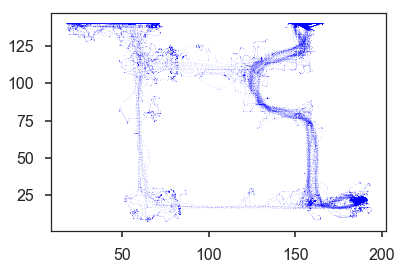

In [16]:
task_times = ["prerecord", "pauseA", "pauseB", "postrecord"]
maze_segments = ["u", "shortcut", "novel", "other"]

n_sessions = len(infos)
likelihoods_max = {k: {trajectory: [] for trajectory in maze_segments} for k in task_times}
likelihoods_mean = {k: {trajectory: [] for trajectory in maze_segments} for k in task_times}
likelihoods_sum = {k: {trajectory: [] for trajectory in maze_segments} for k in task_times}

n_all_swrs = {k: 0 for k in task_times}
    
for info in infos:
    print(info.session_id)
    events, position, spikes, lfp, _ = get_data(info)
    
    tuning_curves = get_only_tuning_curves(info,
                                           position,
                                           spikes,
                                           info.task_times["phase3"])

    tc_shape = tuning_curves.shape
    decoding_tc = tuning_curves.reshape(tc_shape[0], tc_shape[1] * tc_shape[2])
    
    # Define zones
    zones = dict()
    zones["u"], zones["shortcut"], zones["novel"] = get_zones(info, position, subset=True)
    combined_zones = zones["u"] + zones["shortcut"] + zones["novel"]
    zones["other"] = ~combined_zones

    # Find SWRs for the whole session
    z_thresh = 2.0
    power_thresh = 3.0
    merge_thresh = 0.02
    min_length = 0.05
    swrs = nept.detect_swr_hilbert(lfp, fs=info.fs, thresh=(140.0, 250.0), z_thresh=z_thresh,
                                   power_thresh=power_thresh, merge_thresh=merge_thresh, min_length=min_length)
    swrs = nept.find_multi_in_epochs(spikes, swrs, min_involved=4)

    rest_epochs = nept.rest_threshold(position, thresh=12., t_smooth=0.8)

    # Restrict SWRs to those during epochs of interest during rest
    task_times = ["prerecord", "pauseA", "pauseB", "postrecord"]
    
    session_likelihoods_max = {k: {trajectory: [] for trajectory in maze_segments} for k in task_times}
    session_likelihoods_mean = {k: {trajectory: [] for trajectory in maze_segments} for k in task_times}
    session_likelihoods_sum = {k: {trajectory: [] for trajectory in maze_segments} for k in task_times}

    for i, task_time in enumerate(task_times):
        epochs_of_interest = info.task_times[task_time].intersect(rest_epochs)

        phase_swrs = epochs_of_interest.overlaps(swrs)
        phase_swrs = phase_swrs[phase_swrs.durations >= 0.05]
        
        likelihoods = []
        n_all_swrs[task_time] += phase_swrs.n_epochs

        for i, (start, stop) in enumerate(zip(phase_swrs.starts, phase_swrs.stops)):
            likelihood = get_likelihood(spikes, tuning_curves, start, stop)
            
            likelihoods.append(likelihood)
            
            for trajectory in maze_segments:
                likelihoods_max[task_time][trajectory].append(np.nanmax(likelihood[zones[trajectory]]))
                likelihoods_mean[task_time][trajectory].append(np.nanmean(likelihood[zones[trajectory]]))
                likelihoods_sum[task_time][trajectory].append(np.nansum(likelihood[zones[trajectory]]))
                
                session_likelihoods_max[task_time][trajectory].append(np.nanmax(likelihood[zones[trajectory]]))
                session_likelihoods_mean[task_time][trajectory].append(np.nanmean(likelihood[zones[trajectory]]))
                session_likelihoods_sum[task_time][trajectory].append(np.nansum(likelihood[zones[trajectory]]))

                
            if plot_individual:
                filename = info.session_id + "_" + task_time + "_summary-swr" + str(i) + "_average.png"
                filepath = os.path.join(output_filepath, "swr", "mean", filename)
                means = [np.nanmean(likelihood[zones[trajectory]]) for trajectory in maze_segments]
                plot_summary_individual(info, means, position, lfp, spikes, start, stop, likelihood, 
                                        zones, filepath, savefig=True)

                filename = info.session_id + "_" + task_time + "_summary-swr" + str(i) + "_max.png"
                filepath = os.path.join(output_filepath, "swr", "max", filename)
                means = [np.nanmax(likelihood[zones[trajectory]]) for trajectory in maze_segments]
                plot_summary_individual(info, means, position, lfp, spikes, start, stop, likelihood, 
                                        zones, filepath, savefig=True)

                filename = info.session_id + "_" + task_time + "_summary-swr" + str(i) + "_sum.png"
                filepath = os.path.join(output_filepath, "swr", "sum", filename)
                means = [np.nansum(likelihood[zones[trajectory]]) for trajectory in maze_segments]
                plot_summary_individual(info, means, position, lfp, spikes, start, stop, likelihood, 
                                        zones, filepath, savefig=True)
        
        filename = info.session_id+"-average-likelihood-overspace_"+task_time
        
        plot_likelihood_overspace(info, position, likelihoods, zones, filename)
      
    if plot_session:
        filename = info.session_id + " average posteriors during SWRs_max"
        plot_combined(session_likelihoods_max, n_all_swrs, task_times, maze_segments, n_sessions, filename)

        filename = info.session_id + " average posteriors during SWRs_mean"
        plot_combined(session_likelihoods_mean, n_all_swrs, task_times, maze_segments, n_sessions, filename)

        filename = info.session_id + " average posteriors during SWRs_sum"
        plot_combined(session_likelihoods_sum, n_all_swrs, task_times, maze_segments, n_sessions, filename)

        filename = info.session_id + " average posteriors during SWRs_sum-stacked"
        plot_stacked_summary(session_likelihoods_sum, n_all_swrs, task_times, maze_segments, n_sessions, filename)

filename = "Average posteriors during SWRs_max"
plot_combined(likelihoods_max, n_all_swrs, task_times, maze_segments, n_sessions, filename)

filename = "Average posteriors during SWRs_mean"
plot_combined(likelihoods_mean, n_all_swrs, task_times, maze_segments, n_sessions, filename)

filename = "Average posteriors during SWRs_sum"
plot_combined(likelihoods_sum, n_all_swrs, task_times, maze_segments, n_sessions, filename)

filename = "Average posteriors during SWRs_sum-stacked"
plot_stacked_summary(likelihoods_sum, n_all_swrs, task_times, maze_segments, n_sessions, filename)

In [17]:
likelihoods

[]